# Fit annular Zernike coefficients to donuts where the images are masked
<br>Owner(s): **Andy Connolly** (@connolly)
<br>Last Verified to Run: **2021-03-12**
<br>Verified Stack Release: **NA**

Fit Zernike's to masked AOS donut images using an orthogonal projection

For an Image I(k) which has good pixels given by a mask W(k), we want to fit a set of annular Zernikes $Z_i (k)$ and derive the expansion coefficients $a_i$ such that we minimize,

$
\chi^2 = \sum_i \sum_k W(I - a_i Z_i)^2
$

with $k$ specifying a particular pixel. Solving for $a_i$ we get

$
a_i = \sum_i M_{ij}^{-1} F_j 
$

with, 

$
M_{ij} = \sum_k (Z_i Z_j)
$

and
$
F_j = \sum_k I Z_j
$

The issue is that the $Z_i$ are only orthogonal over the full pixel space, masked data means that the Zernikes "mix" or are correalted and no longer orthogonal. The matrix $M_{ij}$ is the mixing matrix which by inverting decorrelates the expansion coefficients.  

This notebook generates a set of example donuts (from a random set of Zernike coefficients), applies the standard Zernike coefficient fitting code in ts_wep, applies the masked Zernike fits and compares the results.

### Logistics
This notebook is intended to be run on the LSP `https://lsst-lsp-stable.ncsa.illinois.edu/nb' It can be run with any software stack with ts_wep installed

In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
%matplotlib inline

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from lsst.ts.wep.cwfs.Tool import ZernikeAnnularEval, ZernikeMaskedFit
import matplotlib.colors as colors

mpl.rc('image', cmap='jet')

In [4]:
import lsst.ts.analysis.notebooks.aos.eigenZernicke as eZ
from lsst.ts.analysis.notebooks.aos.plotUtils import  plotZernikeFits

In [5]:
#set up the pupil
x1d = np.linspace(-1,1,201)
e = 0.61

nzc = 11 #number of zernike in input wavefront
nzr = 10 #r for reconstruction
np.random.seed(1000)
zc = np.random.normal(size=nzc) #z1-z11
zc[-1]=0.2 #we use this term to represent higher order terms, not too big

In [7]:
#create wavefront assuming all pixels are good
# Note the mask=1 defines the "good" pixels
cut = -1.0
x, y = np.meshgrid(x1d, x1d)
r = np.sqrt(x**2 + y**2)
idx = (r>1) | (r<e) | ((x< cut))

x[idx] = np.nan
y[idx] = np.nan
r[idx] = np.nan

# create wavefront for valid pixels (invalid pixels are set to Nan)
w = ZernikeAnnularEval(zc, x, y, e)
mask =  ~np.isnan(w)

#add noise to the wavefront
w = w + np.random.normal(scale=1., size=w.shape) # noise

zimages = eZ.createZernikeList(nzr, x, y, e)

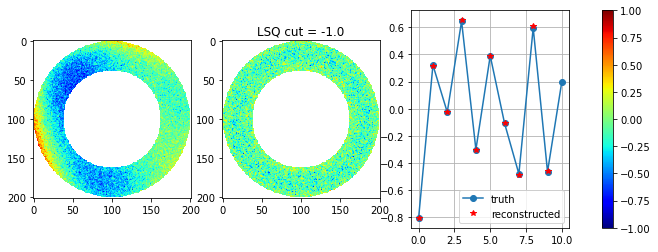

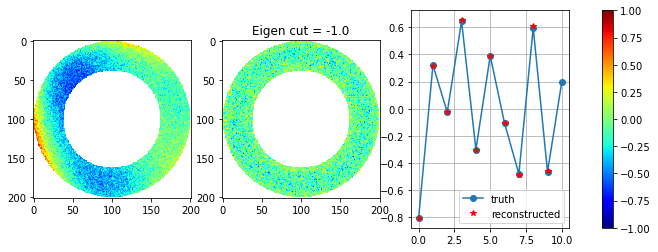

In [8]:
# calculate the zernike coefficients use ts_wep and Zernike projection and plot results
zr = ZernikeMaskedFit(w, x, y, nzr, mask, e)
wLSFit = eZ.reconstructWavefront(zr, zimages)

plotZernikeFits(w, wLSFit, zc, zr, cut=cut, title='LSQ')

#using zernike projection
evalues = eZ.zernikeProjection(w, zimages[0:nzr], mask)
corr = eZ.correlationMatrix(zimages[0:nzr], mask)
fitCoeffs = eZ.zernikeProjectionMaskCorrection(evalues, corr)
wEigenFit = eZ.reconstructWavefront(fitCoeffs, zimages[0:nzr])

plotZernikeFits(w, wEigenFit, zc, fitCoeffs, cut=cut, title='Eigen')

In [9]:
#create wavefront and mask pixels given an arbitrary cut
# Note the mask=1 defines the "good" pixels
cut = -0.6
x, y = np.meshgrid(x1d, x1d)
r = np.sqrt(x**2 + y**2)
idx = (r>1) | (r<e) | ((x< cut))
#idx = (r>1) | (r<e) | ((x< cut) & (x> cut-0.4))
#idx = (r>1) | (r<e) | ((x< cut) | (y< cut))

x[idx] = np.nan
y[idx] = np.nan
r[idx] = np.nan

# create wavefront for valid pixels (invalid pixels are set to Nan)
w = ZernikeAnnularEval(zc, x, y, e)
mask =  ~np.isnan(w)

#add noise to the wavefront
w = w + np.random.normal(scale=1., size=w.shape) # noise

zimages = eZ.createZernikeList(nzr, x, y, e)

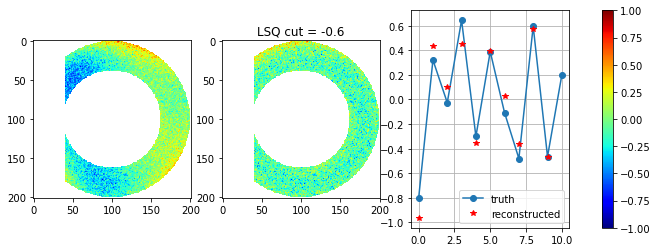

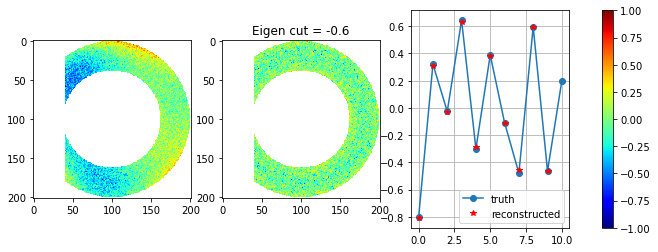

In [10]:
# calculate the zernike coefficients use ts_wep and Zernike projection and plot results
zr = ZernikeMaskedFit(w, x, y, nzr, mask, e)
wLSFit = eZ.reconstructWavefront(zr, zimages)

plotZernikeFits(w, wLSFit, zc, zr, cut=cut, title='LSQ')

#using zernike projection
evalues = eZ.zernikeProjection(w, zimages[0:nzr], mask)
corr = eZ.correlationMatrix(zimages[0:nzr], mask)
fitCoeffs = eZ.zernikeProjectionMaskCorrection(evalues, corr)
wEigenFit = eZ.reconstructWavefront(fitCoeffs, zimages[0:nzr])

plotZernikeFits(w, wEigenFit, zc, fitCoeffs, cut=cut, title='Eigen')

### compare sensitivity to cuts in the data

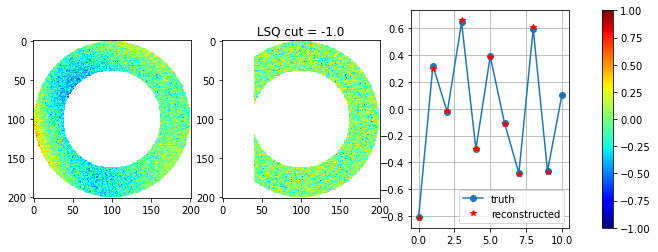

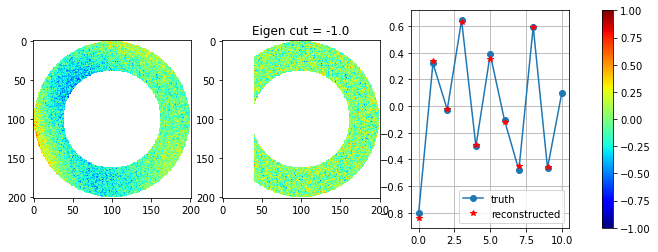

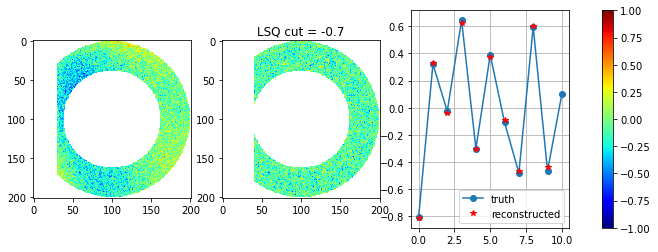

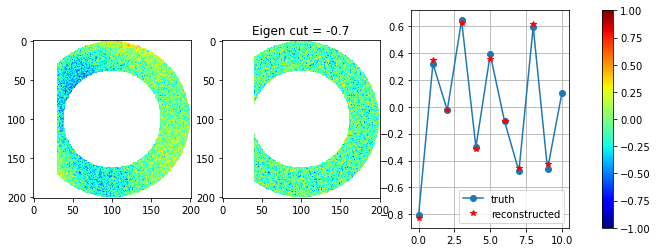

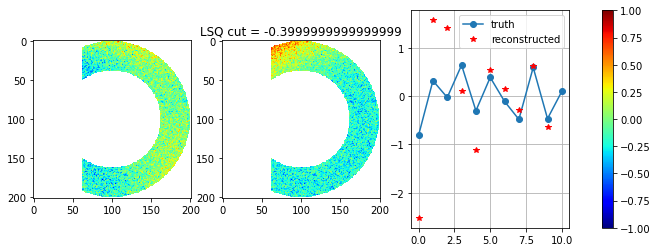

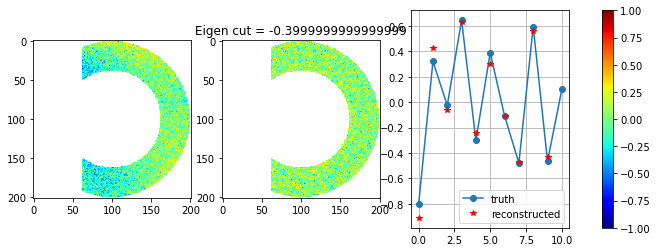

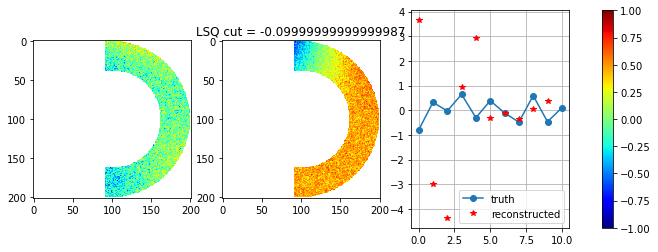

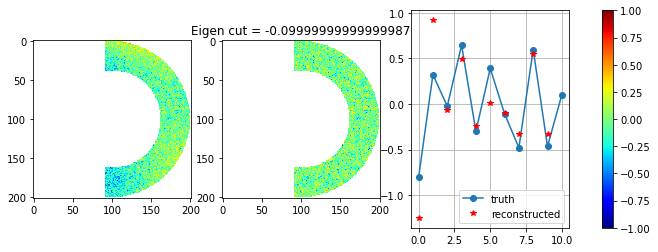

In [11]:
#set up the pupil
x1d = np.linspace(-1,1,201)
e = 0.61

nzc = 11 #number of zernike in input wavefront
nzr = 10 #r for reconstruction
np.random.seed(1000)
zc = np.random.normal(size=nzc) #z1-z22
zc[-1]=0.1 #we use this term to represent "higher order terms, not too big
    
for cut in np.arange(-1.0, 0.0, 0.3):
    x, y = np.meshgrid(x1d, x1d)
    r = np.sqrt(x**2 + y**2)
    idx = (r>1) | (r<e) | (x< cut)
    
    x[idx] = np.nan
    y[idx] = np.nan
    r[idx] = np.nan

    w = ZernikeAnnularEval(zc, x, y, e)
    #add noise
    w = w + np.random.normal(scale=2., size=w.shape)
    mask =  ~np.isnan(x)
    x0c = np.arange(nzc)
    zr = ZernikeMaskedFit(w, x, y, nzr, mask, e)
    x0r = np.arange(nzr)

    #lsq fit
    zr = ZernikeMaskedFit(w, x, y, nzr, mask, e)
    wLSFit = eZ.reconstructWavefront(zr, zimages)
    plotZernikeFits(w, wLSFit, zc, zr, cut=cut, title='LSQ')

    #using zernike projection
    evalues = eZ.zernikeProjection(w, zimages[0:nzr], mask)
    corr = eZ.correlationMatrix(zimages[0:nzr], mask)
    fitCoeffs = eZ.zernikeProjectionMaskCorrection(evalues, corr)
    wEigenFit = eZ.reconstructWavefront(fitCoeffs, zimages[0:nzr])
    plotZernikeFits(w, wEigenFit, zc, fitCoeffs, cut=cut, title='Eigen')
